# Stock Trading algorithm

During the project we used this reasource as guide to extract data from yahoo using yfinance: 
- https://towardsdatascience.com/modeling-your-stock-portfolio-performance-with-python-fbba4ef2ef11


## Single index
To begin with we started developing models that only considers a single stock and then we moved on to more andvanced models that were able to invest in several stocks/indexes at once.



In [ ]:
# Uncomment when running first time to install necessary packages

#!pip install --upgrade pip
#!pip install pandas_datareader
#!pip install yfinance

In [ ]:
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd 
import numpy as np
import datetime

import HelperFunctions
import copy 

# The below will pull back stock prices from the start date until end date specified from yahoo finance using yfinance library.
start_date = datetime.datetime(2001, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

yf.pdr_override()
df_nasdaq = pdr.get_data_yahoo('^IXIC', start_date, end_date) 
df_gold = pdr.get_data_yahoo('GC=F', start_date, end_date) 
df_oil = pdr.get_data_yahoo('CL=F', start_date, end_date) 
df_airline = pdr.get_data_yahoo('LUV', start_date, end_date) # TODO explain a little 

# remove any data that does not exist in all sets
df_gold, df_nasdaq = HelperFunctions.nonMatchRemoveDF(df_gold,df_nasdaq)
df_gold, df_airline = HelperFunctions.nonMatchRemoveDF(df_gold,df_airline)
df_gold, df_oil = HelperFunctions.nonMatchRemoveDF(df_gold,df_oil)
df_gold, df_nasdaq = HelperFunctions.nonMatchRemoveDF(df_gold,df_nasdaq)
df_gold, df_airline = HelperFunctions.nonMatchRemoveDF(df_gold,df_airline)

# create some specific sets used for training and plotting data.
df_goldClass = copy.copy(df_gold[12:])
df_nasdaqClass = copy.copy(df_nasdaq[12:])
df_goldClass2 = copy.copy(df_gold[32:])
df_nasdaqClass2 = copy.copy(df_nasdaq[32:])
df_oilClass2 = copy.copy(df_oil[32:])
df_airlineClass2 = copy.copy(df_airline[32:])
m1, m2 = HelperFunctions.nonMatchRemoveToVector(copy.copy(df_gold), copy.copy(df_nasdaq))
m3, m4 = HelperFunctions.nonMatchRemoveToVector(df_oil,df_airline)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Illustations of data

Example of how the nasdaq data we've extracted looks like

In [ ]:
# Example of how dataframe looks
df_nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,2474.159912,2474.159912,2273.070068,2291.860107,2291.860107,1918930000
2001-01-03,2254.560059,2618.030029,2251.709961,2616.689941,2616.689941,3188000000
2001-01-04,2593.959961,2644.800049,2549.830078,2566.830078,2566.830078,2610680000
2001-01-05,2573.110107,2574.620117,2395.389893,2407.649902,2407.649902,2104670000
2001-01-08,2388.719971,2397.060059,2299.649902,2395.919922,2395.919922,1850590000


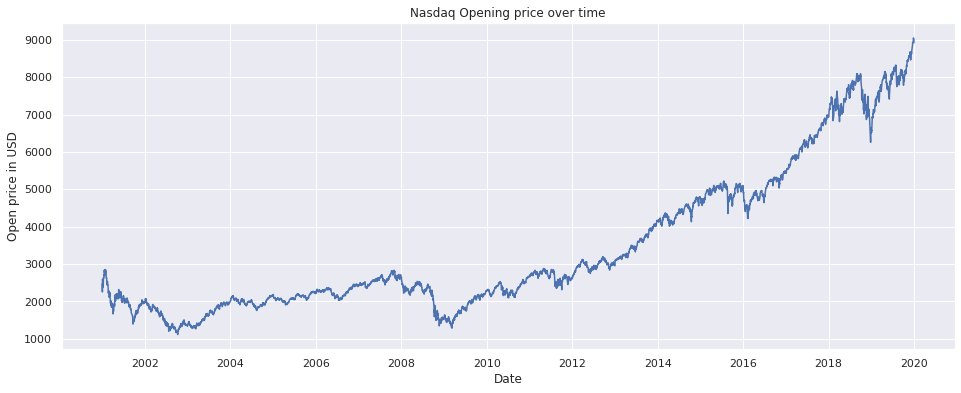

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot of the opening price (which is what we've decided to use in the models) over time.
sns.set(rc={"figure.figsize":(16, 6)}) #width=8, height=4
sns.lineplot(data=df_nasdaq, x='Date', y='Open')
plt.ylabel("Open price in USD")
plt.title("Nasdaq Opening price over time")
plt.show()

### Baselines
Goal of the baselines is to have something to compare rule based models with. We decided to replicate two commonly recognized investment strategies. \
- Baseline 1: Invest X at start
- Baseline 2: Monthly investor


In [ ]:
# Variables to help automatically scale baselines to be comparable
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
default_investment = 100*num_months

# Baseline 1: Growth over time, invest X at start
def ss_base_1(df, investment=default_investment):
    x_start = df.loc[df.index.min(),'Open']
    return [(investment)/x_start for _ in df.index]

# Single Stock Baseline 2: Monthly investor (assuming we can buy partial stocks)
# Assumes that index is the date column
def ss_base_2(df, monthly_investment = default_investment/num_months):
    nmb_owned_stocks = 0
    daily_nmb_of_stocks = []

    # We always make an investment on the first day of the dataset
    this_month = 'none'
    
    for date in df.index:
        # If there is a new month make an investment
        if date.month != this_month:
            this_month = date.month
            open_price = df.loc[date, 'Open']
            nmb_owned_stocks += monthly_investment/open_price

        daily_nmb_of_stocks.append(nmb_owned_stocks)
    
    return daily_nmb_of_stocks

base_1 = ss_base_1(df_nasdaq)
base_2 = ss_base_2(df_nasdaq)

### Rule Based model
Our rule based model for the single stocks consider a window of X days and follows the following rules. 
- If value X days in a row has gone up -> invest all
- If value X days in a row has gone down -> sell all


In [ ]:
# Rule based investment. 
def ss_rule_based(df, investment = default_investment, num_days = 4):
    saved_portfolio_value = investment
    invested = False
    current_owned_stocks = 0

    stored_values = [0 for x in range(num_days)]
    last_value = df.loc[df.index.min(), 'Open']
    ticker = 0

    ret_list = []

    for date in df.index:
        # Sliding window
        todays_value = df.loc[date, 'Open']
        if todays_value > last_value: 
            stored_values[ticker%num_days] = 1
        else: 
            stored_values[ticker%num_days] = 0
        
        last_value = todays_value
        ticker += 1

        if all(elem == 1 for elem in stored_values) and not invested:
            current_owned_stocks = saved_portfolio_value/todays_value
            invested = True
        
        if all(elem == 0 for elem in stored_values) and invested: 
            saved_portfolio_value = current_owned_stocks * todays_value
            current_owned_stocks = 0
            invested = False 
        
        ret_list.append(current_owned_stocks)

    return ret_list

rule_based = ss_rule_based(df_nasdaq)

### Evaluation

Here we have compared 5 models. \
ss_base_1: An investor that makes a lump investment at the start of the time period.\
ss_base_2: An investor that invest the same amount every month \
rule_based_X: Rule based model described above testing window size of 2,3 and 4

In the following two plots we can see first the cumulative return and the total profit of the sifferent models. Notably we can see that the first two models have the same cumulative return but they differ in total profit. In this example the lump investor "wins" but in some cases, especially when the market has gone down in the beginning of the time span we can see that the monthly investor ends up with higher total profit since it's sometimes able to invest in stocks that have lower values than the starting value. 

For this comparison we wanted to have a large time span though so we could see how robust the rule based models were. The best performing model out of several tested time spans was (we've not included all plots here but if you want to see you can change the start and end date at beginning of notbook) was the rulebased model were x=4. We can see that this model mitigates some of the loss when the market decreases a lot over a shorter period of time but this effet also works in the other direction where it may loose out of a lot of potential gain. Overall the rule based models we've implemented flatten out the curve and the best one gives you some profit but significantly reduces the amount compared to the baselines. 

In [ ]:
model_names = ['ss_base_1', 'ss_base_2']
model_res = [base_1, base_2]

# Create a number of rule based models that have different span of days that they consider 
for i in range(2, 5, 1):
    rule_based = ss_rule_based(df_nasdaq, num_days=i)
    model_names.append(f'rule_based_{i}')
    model_res.append(rule_based)

# Analyze is a helper function that returns a dataframe containing cumulative return and total profit for all model
# Dataframe structure for analyze of single stock models can be seen below
res = HelperFunctions.analyze(df_nasdaq, model_names, model_res)
res.head()

,Open,High,Low,Close,Adj Close,Volume,ss_base_1,daily_val: ss_base_1,cum_ret: ss_base_1,tot_prof: ss_base_1,...,cum_ret: rule_based_2,tot_prof: rule_based_2,rule_based_3,daily_val: rule_based_3,cum_ret: rule_based_3,tot_prof: rule_based_3,rule_based_4,daily_val: rule_based_4,cum_ret: rule_based_4,tot_prof: rule_based_4
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-02,2474.159912,2474.159912,2273.070068,2291.860107,2291.860107,1918930000,9.215249,22800.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03,2254.560059,2618.030029,2251.709961,2616.689941,2616.689941,3188000000,9.215249,20776.332639,-0.088757,-2023.667361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-04,2593.959961,2644.800049,2549.830078,2566.830078,2566.830078,2610680000,9.215249,23903.987297,0.048420,1103.987297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-05,2573.110107,2574.620117,2395.389893,2407.649902,2407.649902,2104670000,9.215249,23711.850702,0.039993,911.850702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-08,2388.719971,2397.060059,2299.649902,2395.919922,2395.919922,1850590000,9.215249,22012.649654,-0.034533,-787.350346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


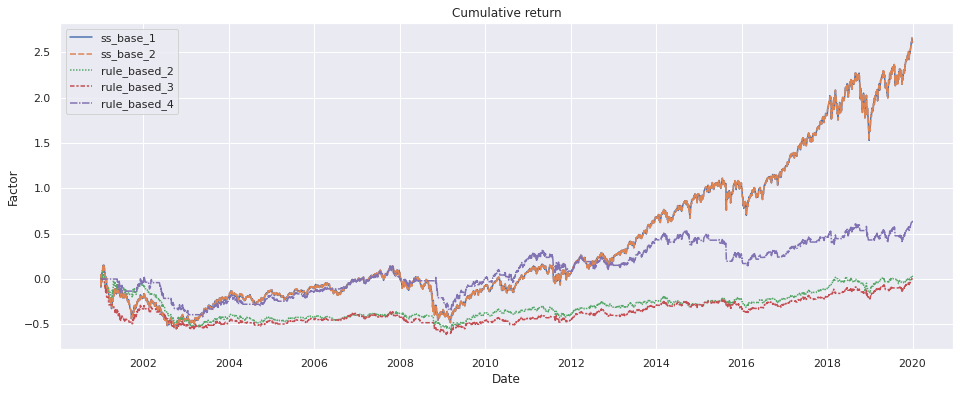

In [ ]:
# Cumulative return plot of the different models
HelperFunctions.plot_cum_ret(res, model_names)

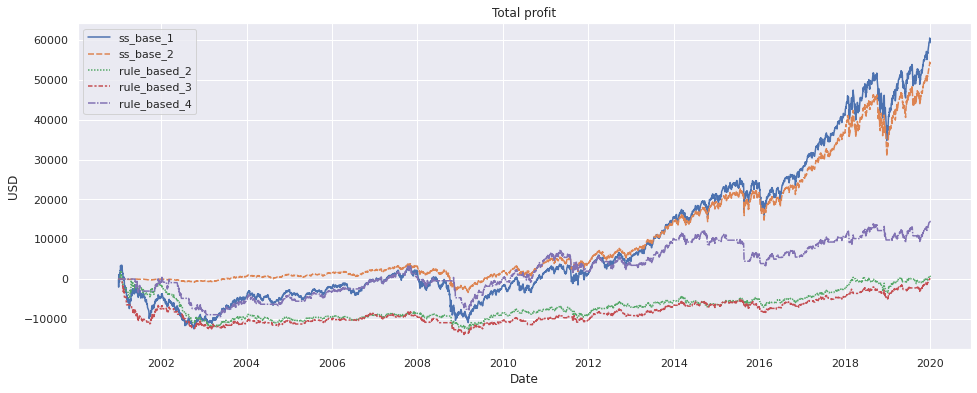

In [ ]:
# Total profit plot of the different models
HelperFunctions.plot_tot_prof(res, model_names)

## More than one stock
Now we move on to more complex models that can invest in more than one stock at a time. For this we've implemented the same evaluation helper function as single stock but adapted it to work for multiple stocks and multiple models. 

### Negatively correlated stocks

Gold is supposed to be slightly negatively correlated to the stock market. Therefore we started with a simple comparison of what would happened if you split half half in gold and nasdaq. We scaled the investments so that all models make the same start investment. The conclusion to this experiment was that we didn't quite find that nasdaq and gold were negatively correlated enough to improve significantly upon the best single stock. It does produce a more steady upward trending curve. We did try to create some "smarter models that try to predict which of the two stocks will outperform the other the next day and change the investemnt based on the prediction using KNN, Logistic regression and LSTM which can be seen below. 

In [ ]:
stock_names = ['Gold', 'NASDAQ']
stock_dfs = [copy.copy(df_goldClass), copy.copy(df_nasdaqClass)]
model_names = ['just_gold', 'just_nasdaq', 'half']


gold_start_price = df_goldClass.loc[df_goldClass.index.min(),'Open']
nasdaq_start_price = df_nasdaqClass.loc[df_goldClass.index.min(), 'Open']
start_investment = 1000

gold_shares = start_investment/gold_start_price
nasdaq_shares = start_investment/nasdaq_start_price

nmb_days = len(df_goldClass.index)
own_list = [1 for _ in range(nmb_days)]
no_own_list = [0 for _ in range(nmb_days)]
half_own_list = [0.5 for _ in range(nmb_days)]

just_gold = [np.array(own_list) * gold_shares, no_own_list]
just_nasdaq = [no_own_list, np.array(own_list)* nasdaq_shares]
half = [np.array(half_own_list) * gold_shares, np.array(half_own_list) * nasdaq_shares]

model_res = [just_gold, just_nasdaq, half]
multi_an = HelperFunctions.multi_analyze(stock_dfs, stock_names, model_names, model_res)

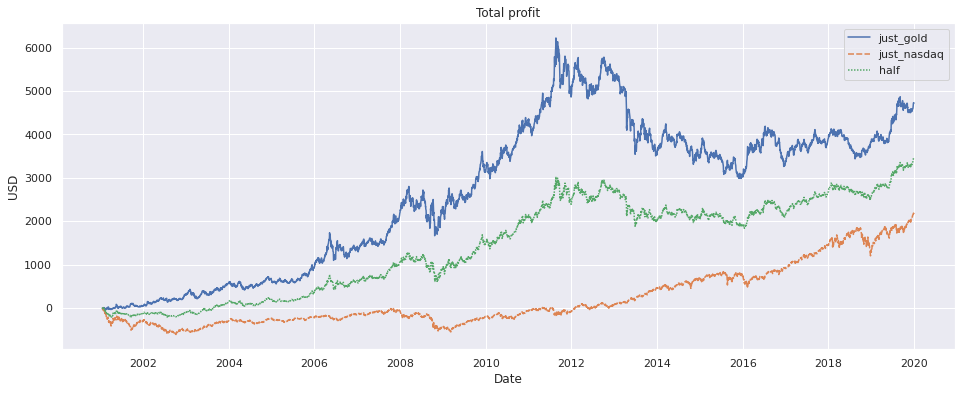

In [ ]:
HelperFunctions.plot_tot_prof(multi_an, model_names)

# KNN

The first attempt is by using KNN. The vector input is represented by 10 consecutive days of:

$ \frac{\frac{goldToday}{goldYesterday}}{\frac{nasdaqToday}{nasdaqYesterday}} $

The output vector is one if gold increased more than nasdaq and 0 otherwise.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = HelperFunctions.getXandYVectorExtra(copy.copy(m1),copy.copy(m2))

train_X, test_X, train_Y,test_Y = train_test_split(X,y,shuffle=False)

classes = np.unique(train_Y)
nClasses = len(classes)

for i in range(25):
    neigh = KNeighborsClassifier(n_neighbors=i+1)
    neigh.fit(train_X, train_Y)
    print(f"i: {i}" , neigh.score(test_X, test_Y, sample_weight=None))

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X, y)
y_pred = neigh.predict_proba(X)

i: 0 0.5088458298230834
i: 1 0.514743049705139
i: 2 0.5113732097725358
i: 3 0.5096882898062342
i: 4 0.5080033698399326
i: 5 0.5290648694187026
i: 6 0.5046335299073293
i: 7 0.5122156697556866
i: 8 0.5012636899747261
i: 9 0.4987363100252738
i: 10 0.4877843302443134
i: 11 0.5004212299915753
i: 12 0.493681550126369
i: 13 0.5029486099410277
i: 14 0.4911541701769166
i: 15 0.5096882898062342
i: 16 0.5054759898904801
i: 17 0.514743049705139
i: 18 0.502106149957877
i: 19 0.5037910699241785
i: 20 0.481044650379107
i: 21 0.4869418702611626
i: 22 0.4928390901432182
i: 23 0.5054759898904801
i: 24 0.4987363100252738


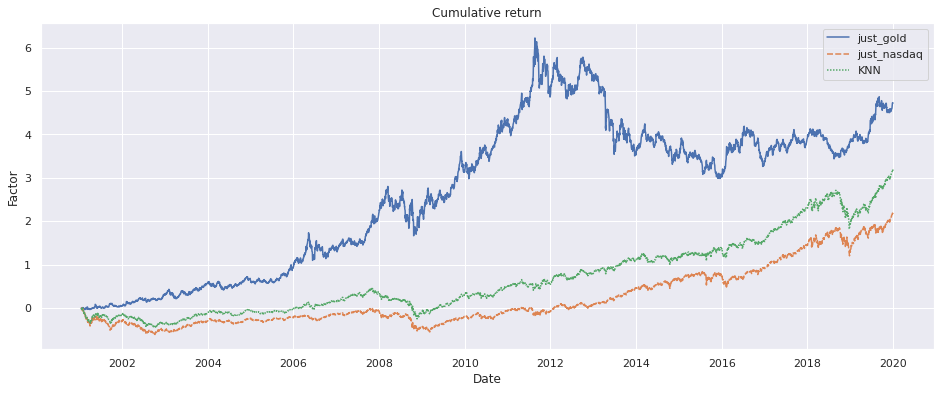

In [ ]:
stock_names = ['Gold', 'NASDAQ']
stock_dfs = [copy.copy(df_goldClass), copy.copy(df_nasdaqClass)]
model_names = ['just_gold', 'just_nasdaq', 'KNN']

nmb_days = len(df_goldClass.index)
own_list = [1 for _ in range(nmb_days)]
no_own_list = [0 for _ in range(nmb_days)]
KNNgold = [elem[0] for elem in y_pred]
KNNnasdaq = [elem[1] for elem in y_pred]

just_gold = [own_list, no_own_list]
just_nasdaq = [no_own_list, own_list]
KNN = [KNNgold, KNNnasdaq]

model_res = [just_gold, just_nasdaq, KNN]
multi_an = HelperFunctions.multi_analyze(stock_dfs, stock_names, model_names, model_res)
HelperFunctions.plot_cum_ret(multi_an, model_names)

# Logistic regression

Logistic regression on the same data as the KNN set.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, y)
print(clf.score(X, y))
y_pred = clf.predict_proba(X)
print(y_pred[0:5])

0.5278011794439764
[[0.50273562 0.49726438]
 [0.49505296 0.50494704]
 [0.48817538 0.51182462]
 [0.56074665 0.43925335]
 [0.51990579 0.48009421]]


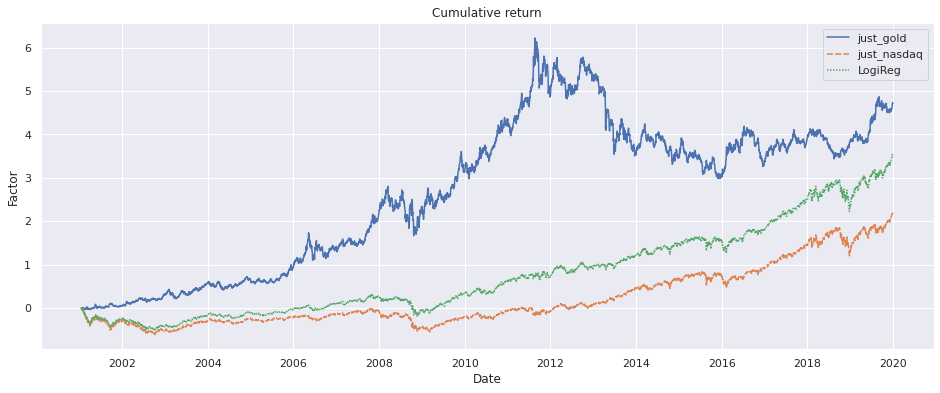

In [ ]:
stock_names = ['Gold', 'NASDAQ']
stock_dfs = [copy.copy(df_goldClass), copy.copy(df_nasdaqClass)]
model_names = ['just_gold', 'just_nasdaq', 'LogiReg']

nmb_days = len(df_goldClass.index)
own_list = [1 for _ in range(nmb_days)]
no_own_list = [0 for _ in range(nmb_days)]
KNNgold = [elem[0] for elem in y_pred]
KNNnasdaq = [elem[1] for elem in y_pred]

just_gold = [own_list, no_own_list]
just_nasdaq = [no_own_list, own_list]
KNN = [KNNgold, KNNnasdaq]

model_res = [just_gold, just_nasdaq, KNN]
multi_an = HelperFunctions.multi_analyze(stock_dfs, stock_names, model_names, model_res)
HelperFunctions.plot_cum_ret(multi_an, model_names)

# LSTM on a vector

LSTM on the same data as KNN and Logistic regression.

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

X, y = HelperFunctions.getXandYVector(copy.copy(m1),copy.copy(m2))
train, validation, train_target,validation_target = train_test_split(X,y,shuffle=False)

model = Sequential()
model.add(LSTM(256, input_shape=(10, 1)))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=11, batch_size=128, validation_data=(validation,validation_target))

from sklearn.metrics import accuracy_score
y_pred = model.predict(X)
y_pred = y_pred.tolist()

Epoch 1/11
28/28 [==============================] - 5s 97ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6917 - val_accuracy: 0.5459
Epoch 2/11
28/28 [==============================] - 2s 73ms/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6917 - val_accuracy: 0.5459
Epoch 3/11
28/28 [==============================] - 2s 72ms/step - loss: 0.6929 - accuracy: 0.5111 - val_loss: 0.6913 - val_accuracy: 0.5459
Epoch 4/11
28/28 [==============================] - 2s 72ms/step - loss: 0.6929 - accuracy: 0.5111 - val_loss: 0.6915 - val_accuracy: 0.5459
Epoch 5/11
28/28 [==============================] - 2s 71ms/step - loss: 0.6929 - accuracy: 0.5114 - val_loss: 0.6914 - val_accuracy: 0.5459
Epoch 6/11
28/28 [==============================] - 2s 71ms/step - loss: 0.6927 - accuracy: 0.5111 - val_loss: 0.6912 - val_accuracy: 0.5459
Epoch 7/11
28/28 [==============================] - 2s 73ms/step - loss: 0.6927 - accuracy: 0.5119 - val_loss: 0.6913 - val_accuracy: 0.5459
Epoch 8/11
28

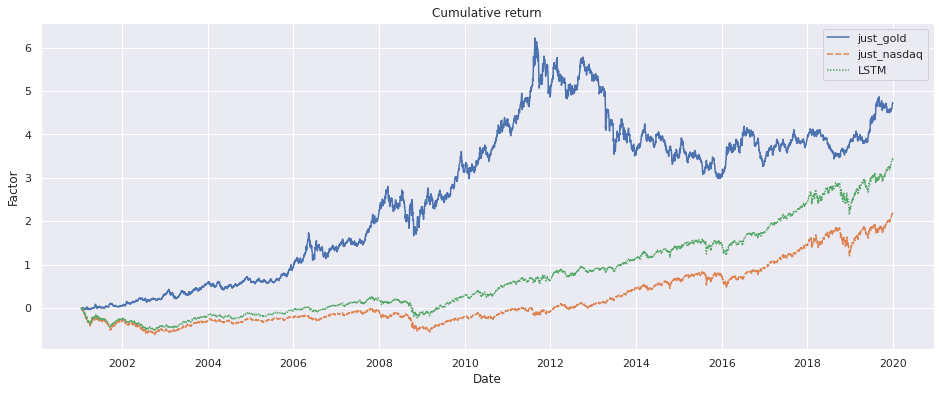

In [ ]:
stock_names = ['Gold', 'NASDAQ']
stock_dfs = [copy.copy(df_goldClass), copy.copy(df_nasdaqClass)]
model_names = ['just_gold', 'just_nasdaq', 'LSTM']

nmb_days = len(df_goldClass.index)
own_list = [1 for _ in range(nmb_days)]
no_own_list = [0 for _ in range(nmb_days)]
KNNgold = [elem[0] for elem in y_pred]
KNNnasdaq = [1-elem[0] for elem in y_pred]

just_gold = [own_list, no_own_list]
just_nasdaq = [no_own_list, own_list]
KNN = [KNNgold, KNNnasdaq]

model_res = [just_gold, just_nasdaq, KNN]
multi_an = HelperFunctions.multi_analyze(stock_dfs, stock_names, model_names, model_res)
HelperFunctions.plot_cum_ret(multi_an, model_names)

# LSTM on 4 stocks

LSTM on four different stocks ( Gold, Nasdaq, Oil and Airlines ). Gold and nasdaq are supposedly negatively correlated and same with oil and the airline industry.

Input data is 30 consecutive days, each day represented by a row. Example of a row is:

[cumulative increase in Gold, in nasdaq, in oil, and in airline company]

Target variable is 0,1,2,3 each representing a class of which stock did best the next day.

Result is an ordered vector of probabilities that each stock would have the highest increase.

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

X, y = HelperFunctions.getXandY4Sets(m1,m2, m3, m4)

train, validation, train_target,validation_target = train_test_split(X,y,shuffle=False)

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape=(30, 4)))
model.add(Dense(4, activation='softmax'))

adam = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=25, batch_size=128, validation_data=(validation,validation_target))

y_pred = model.predict(X)
y_pred = y_pred.tolist()

Epoch 1/25
28/28 [==============================] - 8s 217ms/step - loss: 1.3710 - accuracy: 0.3113 - val_loss: 1.3716 - val_accuracy: 0.3376
Epoch 2/25
28/28 [==============================] - 6s 203ms/step - loss: 1.3610 - accuracy: 0.3260 - val_loss: 1.3655 - val_accuracy: 0.3426
Epoch 3/25
28/28 [==============================] - 6s 202ms/step - loss: 1.3598 - accuracy: 0.3240 - val_loss: 1.3594 - val_accuracy: 0.3376
Epoch 4/25
28/28 [==============================] - 6s 203ms/step - loss: 1.3572 - accuracy: 0.3246 - val_loss: 1.3597 - val_accuracy: 0.3376
Epoch 5/25
28/28 [==============================] - 6s 200ms/step - loss: 1.3580 - accuracy: 0.3243 - val_loss: 1.3593 - val_accuracy: 0.3376
Epoch 6/25
28/28 [==============================] - 6s 198ms/step - loss: 1.3561 - accuracy: 0.3243 - val_loss: 1.3613 - val_accuracy: 0.3376
Epoch 7/25
28/28 [==============================] - 6s 201ms/step - loss: 1.3554 - accuracy: 0.3246 - val_loss: 1.3598 - val_accuracy: 0.3376
Epoch 

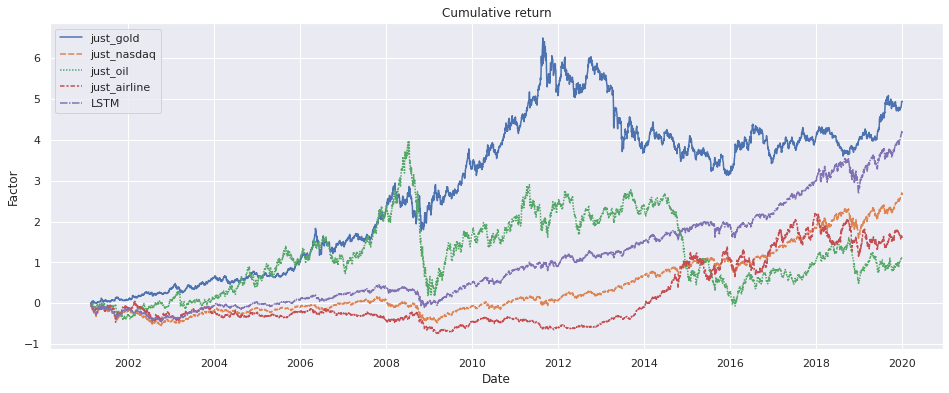

In [ ]:
stock_names = ['Gold', 'NASDAQ', 'Oil','Airlines']
stock_dfs = [copy.copy(df_goldClass2), copy.copy(df_nasdaqClass2), copy.copy(df_oilClass2), copy.copy(df_airlineClass2)]
model_names = ['just_gold', 'just_nasdaq', 'just_oil', 'just_airline', 'LSTM']

nmb_days = len(df_goldClass2.index)
own_list = [1 for _ in range(nmb_days)]
no_own_list = [0 for _ in range(nmb_days)]


just_gold = [own_list, no_own_list, no_own_list, no_own_list]
just_nasdaq = [no_own_list, own_list, no_own_list, no_own_list]
just_oil = [no_own_list, no_own_list,own_list, no_own_list]
just_airline = [no_own_list, no_own_list, no_own_list, own_list]
LSTMgold = [elem[0] for elem in y_pred]
LSTMnasdaq = [elem[1] for elem in y_pred]
LSTMoil = [elem[2] for elem in y_pred]
LSTMairline = [elem[3] for elem in y_pred]
LSTM1 = [LSTMairline,LSTMoil, LSTMnasdaq, LSTMgold]

model_res = [just_gold, just_nasdaq, just_oil, just_airline, LSTM1]
multi_an = HelperFunctions.multi_analyze(stock_dfs, stock_names, model_names, model_res)
HelperFunctions.plot_cum_ret(multi_an, model_names)

### Overfit model
For fun we wanted to try a model that we intentionally overfit 

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape=(30, 4)))
model.add(Dense(4, activation='softmax'))

adam = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=250, batch_size=128, validation_data=(validation,validation_target))

y_pred = model.predict(X)
y_pred = y_pred.tolist()

Epoch 1/250
28/28 [==============================] - 9s 237ms/step - loss: 1.3635 - accuracy: 0.3167 - val_loss: 1.3668 - val_accuracy: 0.3376
Epoch 2/250
28/28 [==============================] - 6s 204ms/step - loss: 1.3579 - accuracy: 0.3243 - val_loss: 1.3644 - val_accuracy: 0.3376
Epoch 3/250
28/28 [==============================] - 6s 207ms/step - loss: 1.3561 - accuracy: 0.3243 - val_loss: 1.3613 - val_accuracy: 0.3376
Epoch 4/250
28/28 [==============================] - 6s 209ms/step - loss: 1.3575 - accuracy: 0.3243 - val_loss: 1.3618 - val_accuracy: 0.3376
Epoch 5/250
28/28 [==============================] - 6s 208ms/step - loss: 1.3558 - accuracy: 0.3243 - val_loss: 1.3614 - val_accuracy: 0.3376
Epoch 6/250
28/28 [==============================] - 6s 203ms/step - loss: 1.3565 - accuracy: 0.3243 - val_loss: 1.3606 - val_accuracy: 0.3376
Epoch 7/250
28/28 [==============================] - 6s 202ms/step - loss: 1.3555 - accuracy: 0.3243 - val_loss: 1.3593 - val_accuracy: 0.3376

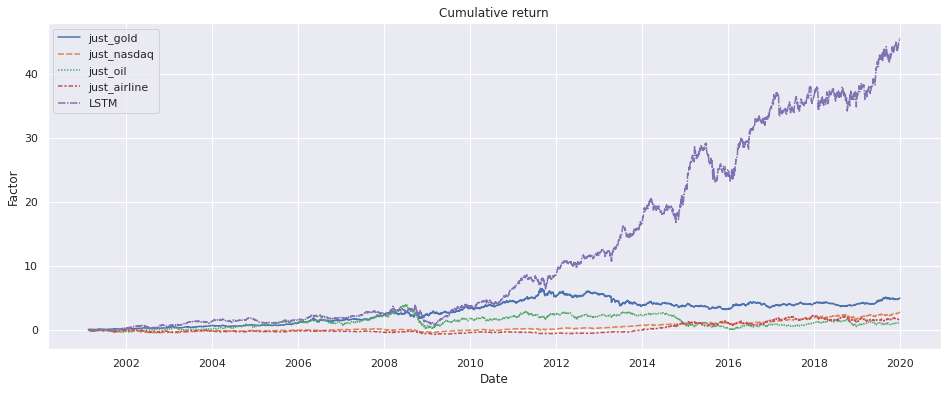

In [ ]:
stock_names = ['Gold', 'NASDAQ', 'Oil','Airlines']
stock_dfs = [copy.copy(df_goldClass2), copy.copy(df_nasdaqClass2), copy.copy(df_oilClass2), copy.copy(df_airlineClass2)]
model_names = ['just_gold', 'just_nasdaq', 'just_oil', 'just_airline', 'LSTM']

nmb_days = len(df_goldClass2.index)
own_list = [1 for _ in range(nmb_days)]
no_own_list = [0 for _ in range(nmb_days)]


just_gold = [own_list, no_own_list, no_own_list, no_own_list]
just_nasdaq = [no_own_list, own_list, no_own_list, no_own_list]
just_oil = [no_own_list, no_own_list,own_list, no_own_list]
just_airline = [no_own_list, no_own_list, no_own_list, own_list]
LSTMgold = [elem[0] for elem in y_pred]
LSTMnasdaq = [elem[1] for elem in y_pred]
LSTMoil = [elem[2] for elem in y_pred]
LSTMairline = [elem[3] for elem in y_pred]
LSTM = [LSTMairline,LSTMoil, LSTMnasdaq, LSTMgold]

model_res = [just_gold, just_nasdaq, just_oil, just_airline, LSTM]
multi_an = HelperFunctions.multi_analyze(stock_dfs, stock_names, model_names, model_res)
HelperFunctions.plot_cum_ret(multi_an, model_names)

## Discussion

From all of these different tests we've determined that: 
- Data extraction was easier than expected using yfinance. We have limited the project by only using Open price and only consider transactions made when the stock market was closed (i.e) between days. We've also not looked into potential stock splits, investment fees etc. But allowed some loss of acuracy by only considering the data as is. 
- Evaluation was supprisingly difficult, both selecting what measurements were relevant and descriptive and also implementing them. We decided to go for cumulative return and total profit since this is what is available for customers when they analyze their portfolio on avanza (which is a recognized platform for investing in stocks in Sweden). We do loose some accuracy due to float precision but we considered it to be negligible. 
- Our simple rule based model actually performed really well on some short time spans (shown below) but over time it wasn't a reliable investment strategy. 
- Building more advanced models was as we expected difficult. After a couple of attempts we managed to get a model that outperformed just averaging out between the selectable stocks. This was with a neural network model using LSTM (Long Short Term Memory) layers while looking at four different stocks. We also did an attempt on a LSTM model that only looked at two stocks and it performed similarly to our KNN and logistic regression model. This draws us to the conclusion that increasing the range of data and parameters while using a neural network approach might be a good idea.


#### Issues that we have not fixed

Currently we are training and validating on overlapping data, and also the plots are on data we have trained on. The data splitting part should have been done manually to not have overlaps between training and validating data, and the plots should mainly focus on the time span of the validation data. We have not fixed this because of the time constraint.

We think this issue might still be okay since both validation and training accuracy are similar, so we hopefully have not have overfit to the data we have. To demonstrate what a completely overfit LSTM model would do with the data we also added a completely overfit LSTM model at the end, mostly for fun.

#### Further improvements

To improve the models we have we feel like a good idea would be to get more data. For example while reading up on info for the assignment we found frameworks that looked at twitter feeds of famous investors and scored them negatively or positively. On the neural network model we could most likely tamper with some different loss functions and parameters to improve the accuracy. A good idea for a model that was actually used in real life would be to have an option to enter data manually to the model based on information aquired from news and what the current world situation looks like.

#### Difficulties with working on the stock market

Finding reliable patterns only looking at graph data is difficult. There are strategies that look at for example support and resistance but in most cases there is always a big gamble anyway. There are too many factors that weighs in to what happens in the stock market and nobody can really predict it completely.

Another difficulty is that to create a good model working on the stock market its neccesary to really understand the stock market, and this is a huge subject that can be very difficult to completely understand.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b9a46de9-d41d-4fe0-9ea0-1a9660fde5f3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>